# 0. Install Dependencies and Bring in Data

In [17]:
!pip install tensorflow pandas matplotlib scikit-learn

^C
ERROR: Operation cancelled by user


In [ ]:
!pip install gradio jinja2

In [50]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import gradio as gr
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding
import pandas as pd
import re
from io import StringIO

In [ ]:
df_main = pd.read_csv(os.path.join('data','train.csv', 'train.csv'))
df_vi = pd.read_csv(os.path.join('data', 'train.csv','ViCTSD_train.csv'))
df_vi = df_vi.rename(columns={"Unnamed: 0": "id", "Comment": "comment_text", "Toxicity": "toxic"})

In [ ]:
common_columns = [col for col in df_vi.columns if col in df_main.columns]

In [ ]:
new_df_filtered = df_vi[common_columns]

# Add missing columns to new_df_filtered with default value 0
for column in df_main.columns:
    if column not in new_df_filtered.columns:
        new_df_filtered[column] = 0

In [ ]:
# Reorder the columns in new_df_filtered to match the order in main_df
new_df_filtered = new_df_filtered[df_main.columns]
new_df_filtered.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,6326,Thật tuyệt vời...!!!,0,0,0,0,0,0
1,7835,"mỹ đã tuột dốc quá nhiều rồi, giờ muốn vực dậy...",0,0,0,0,0,0
2,4690,tôi thấy người lái xe hơi bấm còi mới là người...,1,0,0,0,0,0
3,6011,Coi dịch là giặc. Đã mang tên đó mà xâm nhập V...,0,0,0,0,0,0
4,9303,Thương các bé quá! Các con còn quá nhỏ mà đã p...,0,0,0,0,0,0
5,8959,Sevila đoạt cúp sau loạt đá luân lưu nha,0,0,0,0,0,0
6,64,Angelina Jolie có đôi bàn tay nổi gân guốc quá!,0,0,0,0,0,0
7,5526,"""Tôi không biết bà ấy làm thế nào để xử lý gã ...",0,0,0,0,0,0
8,2082,tấm hình này chắc bộ nhớ máy tính chứa được 1 tấm,0,0,0,0,0,0
9,2936,Không trung sẽ không còn yên tĩnh,0,0,0,0,0,0


In [ ]:
# Append the filtered and adjusted data to the main dataframe
updated_df = pd.concat([df_main, new_df_filtered], ignore_index=True)

# Save the updated dataframe back to the main CSV file
updated_df.to_csv(os.path.join('data','train.csv', 'train.csv'), index=False)

# 1. Preprocess

In [49]:
df = pd.read_csv(os.path.join('data','train.csv', 'train.csv'))

In [54]:
# Define a function to remove emojis and special characters
def remove_special_characters(text):
    # Regular expression to match emojis and special characters
    return re.sub(r'[^\w\s,]', '', text)

# Apply the function to the 'text' column
df['comment_text'] = df['comment_text'].apply(remove_special_characters)

# Display the cleaned DataFrame
print(df)

         id                                       comment_text  toxic
0         0                                           Dừa lắm       0
1         1                                    Bấp bênh vl thế      1
2         2  Chắc cũng biết ko tồn tại đc bao lâu nữa nên c...      1
3         3  Thấy chán ad page này kiến thức thì nông cản c...      1
4         4       Giang Giang Đỗ Thị Ngọc Hà trend mới kìa kìa      0
...     ...                                                ...    ...
15839  9296  đọc tin mà đau lòng quá,thảm nạn cứ xãy ra hoà...      0
15840  3645  Nên mua bạn nhé Để bảo vệ sức khỏe bạn trong 3...      0
15841  5008  Nên ra luật người sử dụng ma túy cũng phạm tội...      0
15842  4343  Mua Fadil đủ lăn bánh Nếu thấy đắt thì đi Morn...      0
15843  5203             2 kẻ này phải xử lý mạnh Thật căm phẫn      1

[15844 rows x 3 columns]


In [55]:
df.shape

(15844, 3)

In [56]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [57]:
MAX_FEATURES = 200000 # number of words in the vocab

In [58]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [59]:
vectorizer.adapt(X.values)

In [60]:
vectorized_text = vectorizer(X.values)

In [61]:
# Step 2: Calculate the length of each sequence
sequence_lengths = [len(tokens) for tokens in vectorizer(X.values)]

# Step 3: Calculate the 95th percentile
percentile_95 = np.percentile(sequence_lengths, 95)

# Print the result
print(f"95th percentile of sequence lengths: {percentile_95}")

95th percentile of sequence lengths: 1800.0


In [62]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(64)
dataset = dataset.prefetch(tf.data.AUTOTUNE) # helps bottlenecks

In [63]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

# 2. Create Sequential Model

In [64]:
model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer 
model.add(Dense(1, activation='sigmoid'))

In [65]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [66]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [67]:
history = model.fit(train, epochs=1, validation_data=val)

173/173 ━━━━━━━━━━━━━━━━━━━━ 311s 2s/step - loss: 0.5897 - val_loss: 0.3282


In [68]:
from matplotlib import pyplot as plt

<Figure size 800x500 with 0 Axes>

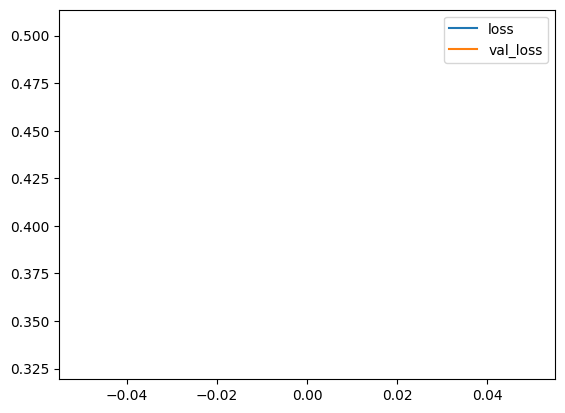

In [69]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

# 3. Make Predictions

In [70]:
input_text = vectorizer('You freaking suck! I am going to hit you.')

In [71]:
res = model.predict(input_text)

ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("sequential_1_1/Cast:0", shape=(32,), dtype=float32). Expected shape (None, 1800), but input has incompatible shape (32,)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(32,), dtype=int64)
  • training=False
  • mask=None

In [ ]:
(res > 0.5).astype(int)

NameError: name 'res' is not defined

In [72]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [73]:
(model.predict(batch_X) > 0.5).astype(int)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 241ms/step


array([[0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]])

In [ ]:
res.shape

NameError: name 'res' is not defined

# 4. Evaluate Model

In [74]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [75]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 322ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


2024-08-16 10:01:54.873453: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [76]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.9245901703834534, Recall:0.6000000238418579, Accuracy:0.0833333358168602


# 5. Test and Gradio

In [ ]:
model.save('vi_toxicity_ver3.h5')

In [77]:
model.save('vi_toxicity_ver3.keras')



In [78]:
model = tf.keras.models.load_model('vi_toxicity_ver3.keras')

In [ ]:
input_str = vectorizer('hey i freaken hate you!')

NameError: name 'vectorizer' is not defined

In [ ]:
res = model.predict(np.expand_dims(input_str,0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step


In [ ]:
res

array([[0.7499008 , 0.01961384, 0.24058144, 0.01534711, 0.26574814,
        0.04420615]], dtype=float32)

In [79]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    
    return text

In [80]:
interface = gr.Interface(fn=score_comment, 
                         inputs=gr.Textbox(lines=2, placeholder='Comment to score'),
                        outputs='text')

In [81]:
interface.launch(share=True)

Running on local URL:  http://127.0.0.1:7862
Running on public URL: https://f1750c84473a054f1e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
